In [1]:
using CSV
using DataFrames
using PyPlot
using Statistics
using Printf

#include("src/timeseries.jl")
rc("font", family="sans-serif", size=16)

In [2]:
overview_df = CSV.read("experiments_ppsn\\overview.csv")
bellman_df = CSV.read("experiments_ppsn\\bellman_notable.csv")
overview_tssa_df = CSV.read("DR Experiments\\summaries\\overview.csv")
efficiency_factor = 5.0

function load_experiment(name)
    if occursin("experiment", name)
        return load_experiment_my(name)
    else
        return load_experiment_tssa(name)
    end
end

function load_experiment_tssa(name)
    df = CSV.read("DR Experiments\\summaries\\$(name).csv")
    df[:time] /= efficiency_factor
    return df
end

function load_experiment_my(name)
    dir = occursin("timed", name) ? "experiments_bt" : "experiments_ppsn"
    df = CSV.read("$(dir)\\$(name).csv")
    rename!(df, Dict(:best_valid_mse => :MSE, :total_time => :time))
    return df
end

function getExperimentsAndLabelsTssa(dataset, consideredLength, remainingPoints)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:consideredLength] == consideredLength && row[:remaining_points] == remainingPoints, overview_tssa_df)
    results = [(relevantEntries[:name][i], relevantEntries[:algo][i]) for i in 1:size(relevantEntries, 1)]
    results_sorted = []
    append!(results_sorted, filter(res -> res[2] == "DBBePSOTSS", results))
    append!(results_sorted, filter(res -> res[2] == "AMCROTSS", results))
    return results_sorted
end

function getExperiment_tssa(dataset, consideredLength, remainingPoints, algo)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:consideredLength] == consideredLength && row[:remaining_points] == remainingPoints && row[:algo] == algo, overview_tssa_df)
    @assert size(relevantEntries, 1) == 1 "$algo on $dataset with n=$consideredLength occurs $(size(relevantEntries, 1)) times"
    return load_experiment(relevantEntries[:name][1])
end

function getDBBePSOTSS(dataset, consideredLength, remainingPoints)
    return getExperiment_tssa(dataset, consideredLength, remainingPoints, "DBBePSOTSS")
end

function getAMCROTSS(dataset, consideredLength, remainingPoints)
    return getExperiment_tssa(dataset, consideredLength, remainingPoints, "AMCROTSS")
end

function getPLAGA(dataset, consideredLength, remainingPoints)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:consideredLength] == consideredLength && row[:remaining_points] == remainingPoints && row[:loop] && occursin("contains special Individuals", row[:description]), overview_df)
    @assert size(relevantEntries, 1) == 1
    return load_experiment(relevantEntries[:name][1])
end

function getPLAGAB(dataset, consideredLength, remainingPoints)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:consideredLength] == consideredLength && row[:remaining_points] == remainingPoints && !row[:loop] && !occursin("contains special Individuals", row[:description]), overview_df)
    @assert size(relevantEntries, 1) == 1
    return load_experiment(relevantEntries[:name][1])
end

function getPLAGAS(dataset, consideredLength, remainingPoints)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:consideredLength] == consideredLength && row[:remaining_points] == remainingPoints && !row[:loop] && occursin("contains special Individuals", row[:description]), overview_df)
    @assert size(relevantEntries, 1) == 1
    return load_experiment(relevantEntries[:name][1])
end

function getPLAGAL(dataset, consideredLength, remainingPoints)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:consideredLength] == consideredLength && row[:remaining_points] == remainingPoints && row[:loop] && !occursin("contains special Individuals", row[:description]), overview_df)
    @assert size(relevantEntries, 1) == 1
    return load_experiment(relevantEntries[:name][1])
end

function getExperimentsAndLabelsMy(dataset, consideredLength, remainingPoints)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:consideredLength] == consideredLength && row[:remaining_points] == remainingPoints, overview_df)
    results = [("name", "label") for i in 1:size(relevantEntries, 1)]
    for i in 1:size(relevantEntries, 1)
        label = "unclassified"
        if relevantEntries[:loop][i]
            if occursin("no special Individuals", relevantEntries[:description][i])
                label = "PLA-GA-L"
            else
                label = "PLA-GA"
            end
        else
            if occursin("no special Individuals", relevantEntries[:description][i])
                label = "PLA-GA-B"
            else
                label = "PLA-GA-S"
            end
        end
        results[i] = (relevantEntries[:name][i], label)
    end
    results_sorted = []
    append!(results_sorted, filter(res -> res[2] == "PLA-GA-B", results))
    append!(results_sorted, filter(res -> res[2] == "PLA-GA-S", results))
    append!(results_sorted, filter(res -> res[2] == "PLA-GA-L", results))
    append!(results_sorted, filter(res -> res[2] == "PLA-GA", results))
    return results_sorted
end

getExperimentsAndLabelsMy (generic function with 1 method)

In [3]:
function min_value_with_budget(df,  t)
    filtered = filter(row -> row.time <= t, df)
    if size(filtered, 1) == 0
        return Inf
    end
    return minimum(filtered.MSE)
end

function bestValuesWithBudget(df, t)
    runs_df = by(df, :run_id) do run_df
        best_value = min_value_with_budget(run_df, t)
    end
    return runs_df.x1
end

function completionTimes(df)
    runs_df = by(df, :run_id, sort=true, :time => maximum)
    return runs_df.time_maximum
end

function getCheckpointAverages(df, time_checkpoints)
    earliest = minimum(completionTimes(df))
    last = maximum(completionTimes(df))
    @show earliest, last
    average_values = []
    for t in time_checkpoints
        append!(average_values, mean(bestValuesWithBudget(df, t)))
    end
    return average_values
end

function getEndtimeMeans(df)
    earliest = minimum(completionTimes(df))
    last = maximum(completionTimes(df))
    endtimes = [earliest, last]
    medi = []
    for t in endtimes
        append!(medi, median(bestValuesWithBudget(df, t)))
    end
    return endtimes, medi
end

function getCheckpointQuantiles(df, time_checkpoints, quant=0.25)
    lower = []
    medi = []
    upper = []
    for t in time_checkpoints
        runs_df = by(df, :run_id) do run_df
            best_value = min_value_after(run_df, t)
        end
        append!(lower, quantile(runs_df[:x1], 0.5-quant))
        append!(medi, median(runs_df[:x1]))
        append!(upper, quantile(runs_df[:x1], 0.5+quant))
    end
    return lower, medi, upper
end

firstQuarter(array) = quantile(array, 0.25)
thirdQuarter(array) = quantile(array, 0.75)

function aggregateByGeneration(df)
    return by(df, [:generation], sort=true, :MSE => mean, :MSE => median, :MSE => firstQuarter, :MSE => thirdQuarter)
end

function finalGenerations(df)
    max_gen = maximum(df[:generation])
    return filter(row -> row[:generation] == max_gen, df)
end

function bellmanData(dataset, consideredLength, remainingPoints)
    entries = filter(row -> row[:dataset] == dataset && row[:length] == consideredLength && row[:remaining_points] == remainingPoints, bellman_df)
    @assert all(mse -> mse == entries.mse[1], entries.mse) "bellman mse inconsistent: $(entries.mse)"
    return median(entries.time), median(entries.mse)
end

function plotProblemWCT(dataset, consideredLength, remainingPoints, time_checkpoints, allowed_my=["PLA-GA-B", "PLA-GA-S", "PLA-GA-L", "PLA-GA"])
    experiments_and_labels_my = getExperimentsAndLabelsMy(dataset, consideredLength, remainingPoints)
    experiments_and_labels_my = filter(pair -> pair[2] in allowed_my, experiments_and_labels_my)
    experiments_and_labels_tssa = getExperimentsAndLabelsTssa(dataset, consideredLength, remainingPoints)
    experiments_and_labels = experiments_and_labels_my + experiments_and_labels_tssa
    quant = 0.25
    max_time = 0
    for pair in experiments_and_labels
        @show pair[2]
        df = load_experiment(pair[1])
        lower, median, upper = getCheckpointQuantiles(df, time_checkpoints, quant)
        fill_between(time_checkpoints, lower, upper, alpha=0.3)
        plot(time_checkpoints, median, label=pair[2])
        endtimes, endmedians = getEndtimeMeans(df)
        max_time = max(max_time, endtimes[2])
        plot(endtimes, endmedians, linestyle="None", color="black", marker="x")
    end
    #time_bellman, value_bellman = bellmanData(dataset, consideredLength, remainingPoints)
    #plot([0, max_time], [value_bellman, value_bellman], color="black", label="Bellman", linestyle="dashed")
    #plot([time_bellman, time_bellman], [0, 100], color="black", linestyle="dashed")
    title("$dataset, n=$consideredLength, m=$remainingPoints")
    ylabel("MSE")
    xlabel("WCT in seconds")
    #yscale("log")
    legend(loc="upper right")
    grid()
end

function formatDataset(name)
    if name == "MALLAT_"
        return "Mallat"
    elseif name == "subject103_5"
        return "Subject5"
    elseif name == "subject103_6"
        return "Subject6"
    else
        return name
    end
end

function plotProblemGenerational(dataset, consideredLength, remainingPoints)
    experiments_and_labels_my = getExperimentsAndLabelsMy(dataset, consideredLength, remainingPoints)
    for pair in experiments_and_labels_my
        @show pair
        generational = aggregateByGeneration(load_experiment(pair[1]))
        plot(generational.generation, generational.MSE_median, label=pair[2])
        fill_between(generational.generation, generational.MSE_firstQuarter, generational.MSE_thirdQuarter, alpha=0.3)
    end
    title("$(formatDataset(dataset)), n=$consideredLength, m=$remainingPoints")
    ylabel("MSE")
    xlabel("iteration")
    legend()
    grid()
end

plotProblemGenerational (generic function with 1 method)

pair = ("experiment2020-04-12_15-55-19-832", "PLA-GA-B")
pair = ("experiment2020-04-13_11-47-05-613", "PLA-GA-S")

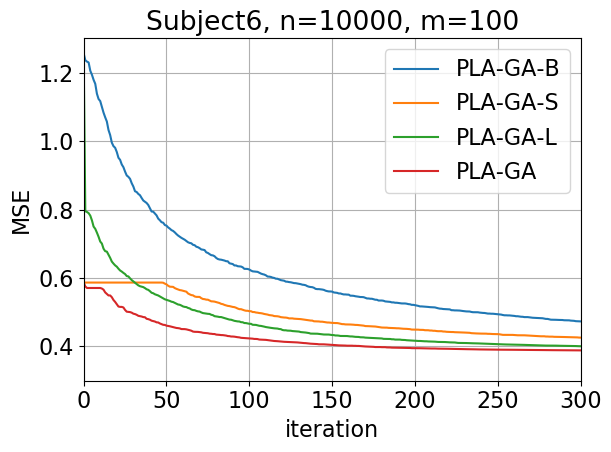


pair = ("experiment2020-04-11_08-15-28-053", "PLA-GA-L")
pair = ("experiment2020-04-10_09-44-30-110", "PLA-GA")


In [22]:
plotSpecs = [("MALLAT_", 8192, (0,250), (0, 0.3)), ("Ham", 10000, (0,300), (0.45, 0.85)), ("Rock", 10000, (0,300), (0.02,0.1)),
    ("subject103_5", 10000, (0,300), (0.1, 0.4)), ("subject103_6", 10000, (0,300), (0.3,1.3)), ("Phoneme", 20000, (0,600), (0.55,0.9)),
    ("HandOutlines", 20000, (0,600), (0, 0.0006)), ("StarLightCurves", 20000, (0,600), (0,0.02))
]
spec = 5
ds = plotSpecs[spec][1]
len = plotSpecs[spec][2]
plotProblemGenerational(ds,len,floor(Int, len*0.01))
xlim(plotSpecs[spec][3])
ylim(plotSpecs[spec][4])
tight_layout()
savefig("Hybrid $ds.png", bbox_inches="tight")

In [6]:
function latexTable(rows)
    result = ""
    for row in rows
        result *= join(scientificNotation.(row), " & ")
        result *= " \\\\\n"
    end
    return result
end

scientificNotation(x::Float64) = @sprintf("%.3g", x)
scientificNotation(x::Int) = x
scientificNotation(s::String) = s

function charsAfterDot(s::String)
    dotIndex = findfirst(isequal('.'), s)
    return length(s) - dotIndex
end

function scalingCoefficient(x::Float64)
    s = @sprintf("%.2e", x)
    eIndex = findfirst(isequal('e'), s)
    scale = parse(Int, s[eIndex+1:end]) - 2
    return scale
end

function formatFloating(x, digits)
    s = string(round(x, digits=digits))
    trailing_zeroes = "0"^(digits - charsAfterDot(s))
    return s * trailing_zeroes
end

function tableRow_ea(dataset, consideredLength, remainingPoints)
    row = []
    push!(row, formatDataset(dataset))
    push!(row, consideredLength)
    particleSwarm = getDBBePSOTSS(dataset, consideredLength, remainingPoints)
    coralReef = getAMCROTSS(dataset, consideredLength, remainingPoints)
    plaga = getPLAGA(dataset, consideredLength, remainingPoints)
    mses = []
    for experiment in [particleSwarm, coralReef]
        generational = aggregateByGeneration(experiment)
        push!(mses, maximum(generational.MSE_median))
        push!(mses, minimum(generational.MSE_median))
    end
    generational = aggregateByGeneration(plaga)
    push!(mses, maximum(generational.MSE_median))
    timeBudget = min(median(completionTimes(particleSwarm)), median(completionTimes(coralReef)))
    push!(mses, median(bestValuesWithBudget(plaga, timeBudget)))
    scale = minimum([scalingCoefficient(mse) for mse in mses])
    push!(row, "\$10^{$scale}\$")
    scaledMses = [round(Int, mse * 10^(-scale)) for mse in mses]
    append!(row, scaledMses)
    return row
end

function tableRow_hybrid(dataset, consideredLength, remainingPoints)
    maxGen = floor(Int, consideredLength * 3 / 100)
    row = []
    push!(row, formatDataset(dataset))
    push!(row, consideredLength)
    experiments = [getExperiment(dataset, consideredLength, remainingPoints) for getExperiment in [getPLAGAB, getPLAGAS, getPLAGAL, getPLAGA]]
    mses = []
    for experiment in experiments
        generational = filter(row -> row[:generation] <= maxGen, aggregateByGeneration(experiment))
        push!(mses, maximum(generational.MSE_median))
        push!(mses, minimum(generational.MSE_median))
    end
    scale = minimum([scalingCoefficient(mse) for mse in mses]) + 1
    push!(row, "\$10^{$scale}\$")
    scaledMses = [round(Int, mse * 10^(-scale)) for mse in mses]
    append!(row, scaledMses)
    return row
end

function tableRow_bellman(dataset, consideredLength, remainingPoints)
    row = []
    push!(row, formatDataset(dataset))
    push!(row, consideredLength)
    time_bellman, mse_bellman = bellmanData(dataset, consideredLength, remainingPoints)
    plaga = getPLAGA(dataset, consideredLength, remainingPoints)
    if minimum(completionTimes(plaga)) < time_bellman
        push!(row, "N/A")
        push!(row, "N/A")
        push!(row, "N/A")
    else
        best_mses = bestValuesWithBudget(plaga, time_bellman)
        mse_plaga = median(best_mses)
        mses = [mse_bellman, mse_plaga]
        scale = minimum([scalingCoefficient(mse) for mse in mses])
        push!(row, "\$10^{$scale}\$")
        scaledMses = [round(Int, mse * 10^(-scale)) for mse in mses]
        append!(row, scaledMses)
        push!(row, formatFloating(mse_plaga / mse_bellman, 2))
        push!(row, formatFloating(minimum(best_mses) / mse_bellman, 2))
    end
    return row
end

hybridProblems = [("MALLAT_", 8192, 81), ("Ham", 10000, 100), ("Rock", 10000, 100), ("subject103_5", 10000, 100), ("subject103_6", 10000, 100), ("HandOutlines", 20000, 200), ("Phoneme", 20000, 200), ("StarLightCurves", 20000, 200)]
duranProblems = [("MALLAT_", 8192, 206), ("Ham", 10000, 251), ("Rock", 10000, 251), ("subject103_5", 10000, 251), ("subject103_6", 10000, 251), ("HandOutlines", 20000, 501), ("Phoneme", 20000, 501), ("StarLightCurves", 20000, 501)]
bellmanQualityProblems = [("MALLAT_", 8192, 81), ("Ham", 10000, 100), ("Ham", 20000, 200), ("Rock", 10000, 100), ("Rock", 20000, 200), ("subject103_5", 10000, 100), ("subject103_5", 30000, 300), ("subject103_6", 10000, 100), ("subject103_6", 30000, 300), ("HandOutlines", 20000, 200), ("Phoneme", 20000, 200), ("Phoneme", 30000, 300), ("StarLightCurves", 20000, 200)]

13-element Array{Tuple{String,Int64,Int64},1}:
 ("MALLAT_", 8192, 81)          
 ("Ham", 10000, 100)            
 ("Ham", 20000, 200)            
 ("Rock", 10000, 100)           
 ("Rock", 20000, 200)           
 ("subject103_5", 10000, 100)   
 ("subject103_5", 30000, 300)   
 ("subject103_6", 10000, 100)   
 ("subject103_6", 30000, 300)   
 ("HandOutlines", 20000, 200)   
 ("Phoneme", 20000, 200)        
 ("Phoneme", 30000, 300)        
 ("StarLightCurves", 20000, 200)

In [7]:
print(latexTable(map(problem -> tableRow_bellman(problem[1], problem[2], problem[3]), bellmanQualityProblems)))

Mallat & 8192 & $10^{-4}$ & 911 & 741 & 0.81 & 0.79 \\
Ham & 10000 & $10^{-3}$ & 522 & 538 & 1.03 & 1.01 \\
Ham & 20000 & $10^{-3}$ & 512 & 496 & 0.97 & 0.96 \\
Rock & 10000 & $10^{-4}$ & 274 & 237 & 0.87 & 0.83 \\
Rock & 20000 & $10^{-3}$ & 270 & 184 & 0.68 & 0.64 \\
Subject5 & 10000 & $10^{-3}$ & 130 & 130 & 1.00 & 0.97 \\
Subject5 & 30000 & $10^{-3}$ & 131 & 121 & 0.92 & 0.91 \\
Subject6 & 10000 & $10^{-3}$ & 404 & 420 & 1.04 & 1.01 \\
Subject6 & 30000 & $10^{-3}$ & 300 & 287 & 0.96 & 0.94 \\
HandOutlines & 20000 & $10^{-7}$ & 1663 & 910 & 0.55 & 0.54 \\
Phoneme & 20000 & $10^{-3}$ & 566 & 573 & 1.01 & 1.00 \\
Phoneme & 30000 & $10^{-3}$ & 546 & 550 & 1.01 & 1.00 \\
StarLightCurves & 20000 & $10^{-5}$ & 418 & 270 & 0.65 & 0.64 \\


In [ ]:
# computational effort of operators
problems = [("MALLAT_", 8192, 81), ("Ham", 10000, 100), ("Rock", 10000, 100), ("subject103_5", 10000, 100), ("subject103_6", 10000, 100), ("HandOutlines", 20000, 200), ("Phoneme", 20000, 200), ("StarLightCurves", 20000, 200)]

function initCosts(df)
    init = filter(row -> row.generation == 0, df)
    init.time
end

function iterationCosts(df)
    costs = []
    runs_df = by(df, :run_id) do run_df
        total_times = sort(run_df.time)
        iteration_times = [total_times[i+1] - total_times[i] for i in 1:length(total_times)-1]
        append!(costs, iteration_times)
    end
    costs
end

function operatorEffort(dataset, consideredLength, remainingPoints)
    print(dataset * "\n")
    experiments_and_labels = getExperimentsAndLabelsMy(dataset, consideredLength, remainingPoints)
    init_vanilla = []
    init_seeding = []
    iteration_vanilla = []
    iteration_loop = []
    for pair in experiments_and_labels
        print("$pair\n")
        df = load_experiment(pair[1])
        init = initCosts(df)
        iter = iterationCosts(df)
        if pair[2] in ("PLA-GA", "PLA-GA-S")
            append!(init_seeding, init)
        else
            append!(init_vanilla, init)
        end
        if pair[2] in ("PLA-GA", "PLA-GA-L")
            append!(iteration_loop, iter)
        else
            append!(iteration_vanilla, iter)
        end
    end
    cost_init = mean(init_vanilla)
    cost_seeding = mean(init_seeding)
    cost_iter = mean(iteration_vanilla)
    cost_loop = mean(iteration_loop)
    print("init: $cost_init, $cost_seeding ($(cost_seeding/cost_init)), $cost_iter, $cost_loop ($(cost_loop/cost_iter)); init is $(cost_init/cost_iter) iter\n")
end

for problem in problems
    operatorEffort(problem[1], problem[2], problem[3])
end

In [ ]:
# use bachelor thesis experiments
overview_df = CSV.read("experiments_bt\\overview_timed.csv")
bellman_df = CSV.read("experiments_bt\\bellman_notable.csv")

function bellmanData(dataset, consideredLength, remainingPoints)
    entries = filter(row -> row[:length] == consideredLength && row[:remaining_points] == remainingPoints, bellman_df)
    time_bellman = median(entries.time)
    entries = filter(row -> row[:dataset] == dataset, entries)
    @assert all(mse -> mse == entries.mse[1], entries.mse) "bellman mse inconsistent: $(entries.mse)"
    return median(entries.time), median(entries.mse)
end

bellmanQualityProblems = [(ds, n*10000, n*100) for n in [1,2,3,4,5] for ds in ["Ham", "Rock", "subject103_5", "subject103_6"]]

In [ ]:
plotProblemGenerational("Donoho-Johnstone",2048,52)
bellman_result = 2.2233501842085495e-5
plot([0, 700], [bellman_result, bellman_result], color="gray", linestyle="dashed", label="Bellman")
legend()
grid()
#pygui(true)
ylim((0, 0.0002))
#savefig("example_ga_plot", bbox_inches="tight")

In [ ]:
printProblemFinal("HandOutlines", 20000, 501)

In [23]:
pygui(false)

false

In [ ]:
print(latexTable(map(problem -> tableRow_ea(problem[1], problem[2], problem[3]), duranProblems)))